/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (209). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (209). n_quantiles is set to n_samples.
  warnings.warn(


Missing values found in the target variable.
Skewness after Quantile Transformation (normal distribution): -0.0000
Skewness after Quantile Transformation (uniform distribution): -0.0000


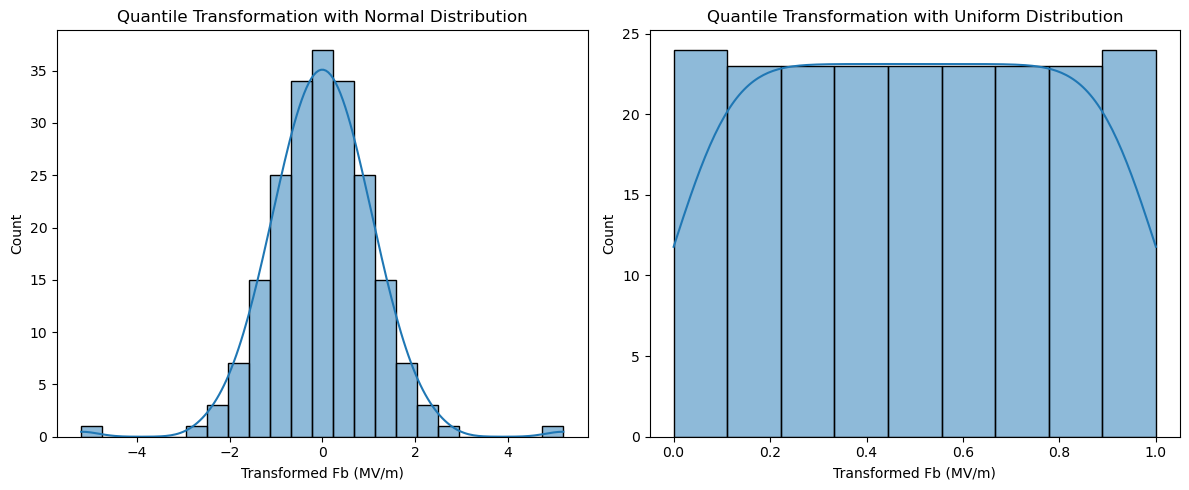

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data
df = pd.read_csv('Perovskite dataset1.csv')

# Target variable column name
target_variable = 'Fb (MV/m)'

# Check for missing values in the target variable and remove if any
if df[target_variable].isnull().any():
    print("Missing values found in the target variable.")
    df = df[df[target_variable].notnull()]

# Separate features and target
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Apply Quantile Transformer for normal and uniform distributions
quantile_transformer_normal = QuantileTransformer(output_distribution='normal', n_quantiles=1000, random_state=42)
y_normal_transformed = quantile_transformer_normal.fit_transform(y.values.reshape(-1, 1)).flatten()

quantile_transformer_uniform = QuantileTransformer(output_distribution='uniform', n_quantiles=1000, random_state=42)
y_uniform_transformed = quantile_transformer_uniform.fit_transform(y.values.reshape(-1, 1)).flatten()

# Check skewness
skewness_normal = skew(y_normal_transformed)
skewness_uniform = skew(y_uniform_transformed)

print(f"Skewness after Quantile Transformation (normal distribution): {skewness_normal:.4f}")
print(f"Skewness after Quantile Transformation (uniform distribution): {skewness_uniform:.4f}")

# Plot transformed distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_normal_transformed, kde=True)
plt.title("Quantile Transformation with Normal Distribution")
plt.xlabel("Transformed Fb (MV/m)")

plt.subplot(1, 2, 2)
sns.histplot(y_uniform_transformed, kde=True)
plt.title("Quantile Transformation with Uniform Distribution")
plt.xlabel("Transformed Fb (MV/m)")

plt.tight_layout()
plt.show()

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(output_distribution='normal', random_state=42), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_normal_transformed, test_size=0.2, random_state=42)



In [27]:
# Model configurations and parameter grids (with SVR removed)
param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, objective='reg:squarederror'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [-1, 10, 20],
            'model__num_leaves': [31, 50]
        }
    },
    'Bagging': {
        'model': BaggingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [10, 50, 100],
            'model__max_features': [0.5, 0.75, 1.0]
        }
    },
   
    }


# Create a pipeline for preprocessing and modeling
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))  # Placeholder model
])

# Evaluate all models and store results
results = {}
best_rmse = float('inf')
best_model_name = None

for model_name, config in param_grids.items():
    pipeline.set_params(model=config['model'])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=config['params'],
                               cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV RMSE (Mean)': -grid_search.best_score_,
        'CV RMSE (Std Dev)': grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    }
    
    # Save the best model if it performs better than previous models
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = model_name
        joblib.dump(best_model, 'best_model.pkl')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (167). n_quantiles is set to n_samples.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 10
[LightGBM] [Info] Start training from score -0.003026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 10
[LightGBM] [Info] Start training from score -0.058675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 167, number of used features: 12
[LightGBM] [Info] Start training from score -0.069853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/Users/ananyabhardwaj/anaconda3/lib/python3.11/site-packages/sklearn/preproc

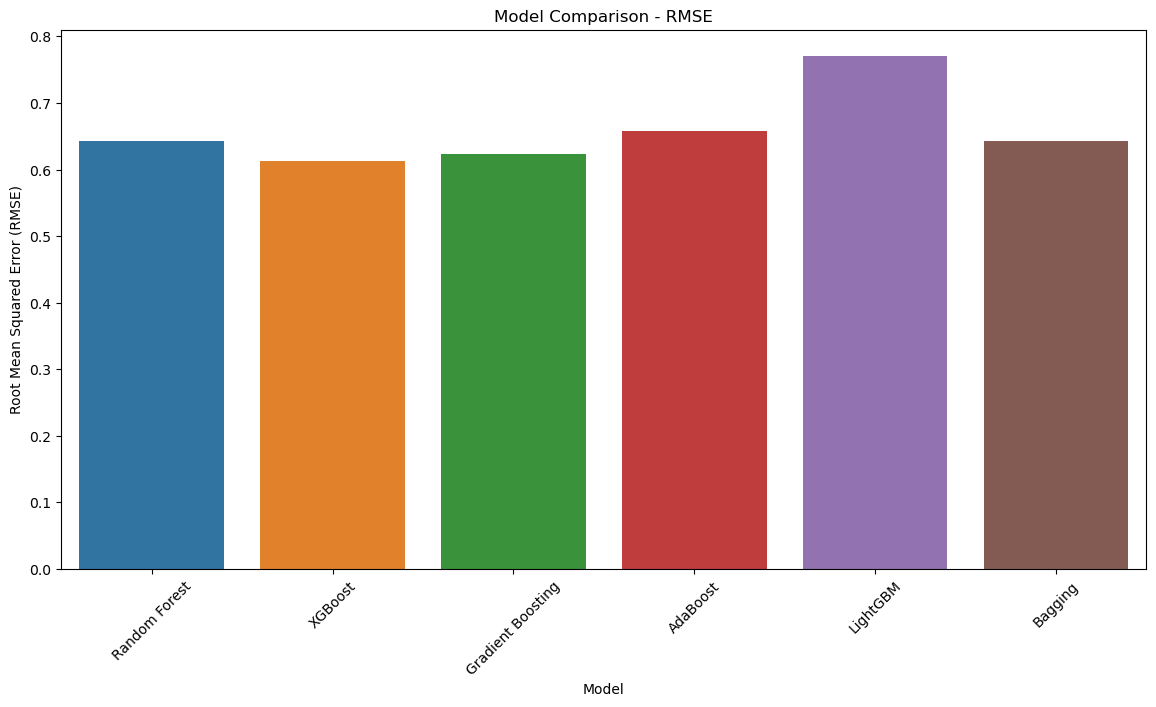

Model Performance Summary:
                         R²      RMSE       MAE CV RMSE (Mean)  \
Random Forest      0.771308  0.642839  0.224653       0.166641   
XGBoost            0.792357  0.612541  0.210989       0.126814   
Gradient Boosting  0.784896  0.623449  0.217486       0.125061   
AdaBoost           0.760349  0.658061  0.253519        0.20339   
LightGBM           0.670738  0.771343  0.294259       0.248341   
Bagging            0.771296  0.642856  0.221867       0.170249   

                  CV RMSE (Std Dev)  
Random Forest              0.036115  
XGBoost                    0.031234  
Gradient Boosting          0.028843  
AdaBoost                   0.037011  
LightGBM                   0.061349  
Bagging                    0.038612  


,R²,RMSE,MAE,CV RMSE (Mean),CV RMSE (Std Dev)
Random Forest,0.771308,0.642839,0.224653,0.166641,0.036115
XGBoost,0.792357,0.612541,0.210989,0.126814,0.031234
Gradient Boosting,0.784896,0.623449,0.217486,0.125061,0.028843
AdaBoost,0.760349,0.658061,0.253519,0.20339,0.037011
LightGBM,0.670738,0.771343,0.294259,0.248341,0.061349
Bagging,0.771296,0.642856,0.221867,0.170249,0.038612


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [28]:
# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T

# Plot model performance
plt.figure(figsize=(14, 7))
sns.barplot(x=results_df.index, y="RMSE", data=results_df)
plt.title("Model Comparison - RMSE")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xticks(rotation=45)
plt.show()

# Print summary of results
print("Model Performance Summary:")
print(results_df[['R²', 'RMSE', 'MAE', 'CV RMSE (Mean)', 'CV RMSE (Std Dev)']])

# Display the final results table
results_df[['R²', 'RMSE', 'MAE', 'CV RMSE (Mean)', 'CV RMSE (Std Dev)']]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 0 to 208
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         209 non-null    object 
 1   Fb (MV/m)    209 non-null    float64
 2   Eg (eV)      209 non-null    float64
 3   ωmax (THz)   209 non-null    float64
 4   a (Å)        209 non-null    float64
 5   b (Å)        209 non-null    float64
 6   c (Å)        209 non-null    float64
 7   α (°)        209 non-null    float64
 8   β (°)        209 non-null    float64
 9   γ (°)        209 non-null    float64
 10  Space group  209 non-null    object 
dtypes: float64(9), object(2)
memory usage: 19.6+ KB
